<h2 style="text-align:center;" > Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.</h2>

<h2 style="text-align:center;" >Tutorial: Uso de prompts de tipo texto en la segmentacion</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

In [4]:
# Instalar dependencias necesarias para LangSAM
!pip install groundingdino-py --upgrade
!pip install segment-geospatial --upgrade
!pip install transformers --upgrade

# Instalar GroundingDINO directamente desde el repositorio
!pip install git+https://github.com/IDEA-Research/GroundingDINO.git
from samgeo.text_sam import LangSAM
import matplotlib.pyplot as plt
import cv2
import torch

# Verificar que CUDA esté disponible
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"Versión de PyTorch: {torch.__version__}")

CUDA disponible: True
Versión de PyTorch: 2.7.1+cu118


In [5]:
sam = LangSAM(model_type="sam2-hiera-large")

NameError: name 'SLConfig' is not defined

In [42]:
prompts_pos = "agua, cuerpo de agua, lago, embalse, superficie de agua, laguna"
sam.predict('../tiles/Sentinel/Guatavita_0_crop.tif', prompts_pos, box_threshold=0.45, text_threshold=0.9)

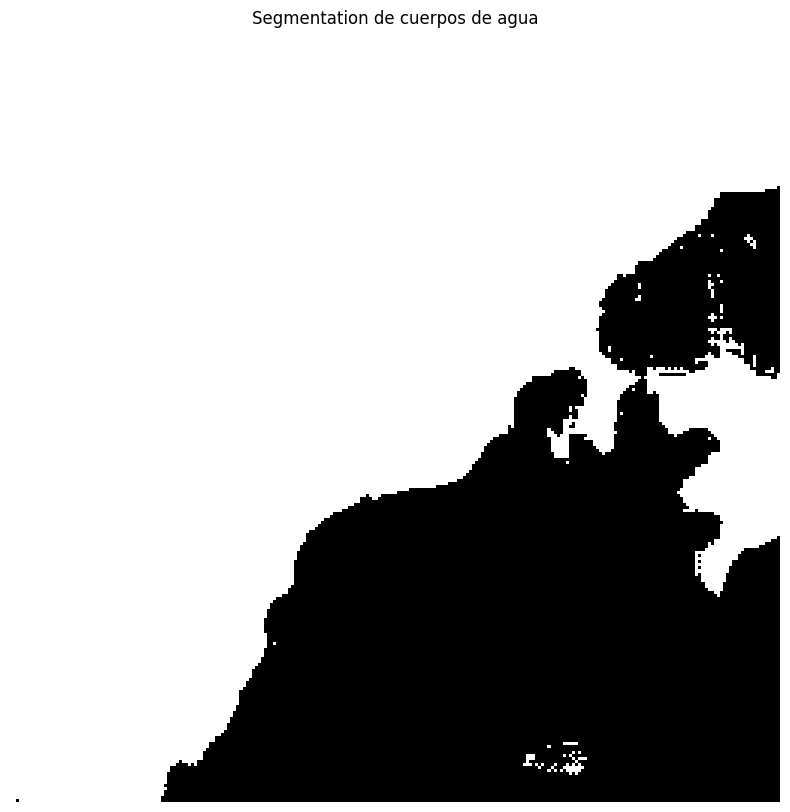

In [48]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Segmentation de cuerpos de agua",
    blend=False,
    output="water_bodies.tif",
)